In [33]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import matplotlib.pyplot as plt

%matplotlib inline

In [34]:
def get_sentences(data_list):
    sentences = []
    for a in data_list.article.unique():
        words = []
        prev_n = 0
        for _,s in data_list.loc[data_list.article == a].iterrows():
            n = s['sentence_no']
            if n != prev_n:
                if len(words) > 2 and len(set([x[1] for x in words])) > 1:
                    sentences.append(words)
                words = []
            words.append((s['word'], s['encoding'], s['part_of_speech']))
            prev_n = n
            
        if len(words) > 2 and len(set([x[1] for x in words])) > 1:
            sentences.append(words)
            
    return sentences

In [35]:
data_list = pd.read_csv('../data/go/go_cc3.csv')
data_list.word.fillna('NA', inplace=True)

temp = pd.read_csv('../data/go/go_bp3.csv')
temp.word.fillna('NA', inplace=True)

temp1 = pd.read_csv('../data/go/go_mf3.csv')
temp1.word.fillna('NA', inplace=True)
temp1 = temp1.rename(columns={'encoding' : 'encoding_z'})

data_list = data_list.merge(temp, on=['article', 'sentence_no', 'word_no'])
data_list = data_list.merge(temp1, on=['article', 'sentence_no', 'word_no'])
data_list.sort_values(['article', 'sentence_no'], kind='mergesort', inplace=True)
x_counts = data_list.encoding_x.value_counts()
y_counts = data_list.encoding_y.value_counts()
z_counts = data_list.encoding_z.value_counts()
# data_list['encoding_x'] = data_list.encoding_x.apply(lambda x: x if x_counts[x] > 4 else 'O')
# data_list['encoding_y'] = data_list.encoding_y.apply(lambda x: x if y_counts[x] > 4 else 'O')
# data_list['encoding'] = [i if (i == 'O' and j == 'O') else j for i,j in zip(data_list.encoding_x, data_list.encoding_y)]
temp_encoding = []
for i,j,k in zip(data_list.encoding_x, data_list.encoding_y, data_list.encoding_z):
    if i == j and j == k:
        temp_encoding.append('O')
    elif i == 'O' and j != 'O':
        temp_encoding.append(j)
    elif j == 'O' and i != 'O':
        temp_encoding.append(i)
    else:
        temp_encoding.append(k)
data_list['encoding'] = temp_encoding
val_cnt = data_list.encoding.value_counts()
data_list['encoding'] = data_list.encoding.apply(lambda x: 'O' if val_cnt[x] < 5 else x)
# data_list['encoding'] = data_list.encoding.apply(lambda x: 'O' if val_cnt[x] >= 5 else x)
# data_list = data_list.rename(columns={'word_x' : 'word'})

In [36]:
data_list = get_sentences(data_list)
print(data_list[0])
print(len(data_list))

words = list(set(y[0] for x in data_list for y in x))
n_words = len(words)
print(n_words)

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags)
print(n_tags)

poss = list(set(y[2] for x in data_list for y in x))
n_poss = len(poss)
print(n_poss)

[('Gender', 'O', 'NN'), ('does', 'O', 'VBZ'), ('not', 'O', 'RB'), ('typically', 'O', 'RB'), ('affect', 'O', 'JJ'), ('IOP', 'O', 'NNP'), ('and', 'O', 'CC'), ('aging', 'GO:0007568', 'VBG'), ('results', 'O', 'NNS'), ('in', 'O', 'IN'), ('an', 'O', 'DT'), ('IOP', 'O', 'NNP'), ('decrease', 'O', 'NN'), ('in', 'O', 'IN'), ('some', 'O', 'DT'), ('strains', 'O', 'NNS'), ('.', 'O', '.')]
7178
15558
258
44


In [37]:
max_len = 75
max_len_char = 15

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["O"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["O"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

pos2idx = {w: i+1 for i, w in enumerate(poss)}
pos2idx["X"] = 0
idx2pos = {i: w for w, i in pos2idx.items()}

In [38]:
print(tag2idx)

{'2_GO:0032391': 1, 'GO:0005634': 2, 'GO:0007566': 3, 'GO:0009294': 4, '2_GO:0001822': 5, '2_GO:0008219': 6, 'GO:0050890': 213, 'GO:0007601': 165, '1_GO:0001739': 9, '3_GO:0043277': 10, '1_GO:0034205': 11, 'GO:0008283': 42, '1_GO:0050913': 12, '1_GO:0001822': 13, 'GO:0071735': 15, 'GO:0006412': 196, 'GO:0007129': 127, '2_GO:0019432': 16, 'GO:0000786': 218, 'GO:0043631': 17, 'GO:0006260': 217, '1_GO:0009790': 19, 'GO:0050909': 21, '1_GO:0001654': 22, '2_GO:0001739': 128, 'GO:0045177': 24, 'GO:0007608': 25, '2_GO:0042461': 27, '1_GO:0043277': 28, '1_GO:0019835': 31, '1_GO:0006006': 32, '1_GO:0060173': 33, '1_GO:0044297': 219, '2_GO:0007129': 49, 'GO:0014069': 34, 'GO:0000237': 35, 'GO:0008152': 36, '2_GO:0006338': 37, '2_GO:0030509': 38, 'GO:0005622': 39, 'GO:0005777': 40, '1_GO:0005721': 41, '1_GO:0060041': 43, '2_GO:0044297': 44, 'GO:0006272': 45, '1_GO:0001741': 223, 'GO:0016265': 46, '2_GO:0000803': 47, '1_GO:0008283': 48, '2_GO:0009790': 90, 'GO:0007599': 173, '1_GO:0031069': 50, '2

In [39]:
print(pos2idx)

{'DT': 1, 'NN': 2, 'VB': 3, 'VBZ': 4, '#': 6, 'POS': 7, 'PRP': 8, 'VBN': 34, 'MD': 9, 'JJ': 10, '$': 11, 'RBR': 12, '(': 13, 'EX': 37, 'VBG': 14, 'CC': 15, 'TO': 18, '.': 17, ',': 20, 'FW': 21, 'WDT': 5, 'WP': 22, '``': 30, 'RP': 24, 'PDT': 25, 'RBS': 26, 'JJR': 27, 'WP$': 28, 'VBP': 29, 'NNS': 23, 'RB': 31, ')': 32, 'SYM': 33, "''": 35, 'IN': 36, 'WRB': 41, 'VBD': 38, 'JJS': 39, 'PRP$': 40, 'UH': 42, 'NNPS': 43, 'NNP': 16, 'CD': 19, ':': 44, 'X': 0}


In [40]:
X_word = [[w[0] for w in s] for s in data_list]
new_X = []
for seq in X_word:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("ENDPAD")
    new_X.append(new_seq)
X_word = new_X

In [41]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

128


In [42]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["O"] = 0

In [43]:
X_char = []
for sentence in data_list:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("O"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


In [44]:
from keras.preprocessing.sequence import pad_sequences
X_pos = [[pos2idx[w[2]] for w in s] for s in data_list]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["X"], padding='post', truncating='post')

In [45]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]
y = pad_sequences(maxlen=max_len, sequences=y,value=tag2idx["O"], padding='post', truncating='post')

In [46]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y]

In [47]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.3, random_state=2018)
X_pos_tr, X_pos_te, _, _ = train_test_split(X_pos, y, test_size=0.3, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.3, random_state=2018)

In [48]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(32*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

INFO:tensorflow:Initialize variable module_1/bilm/CNN/W_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_5
INFO:tensorflow:Initialize variable module_1/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling
INFO:tensorflow:Initialize variable module_1/bilm/CNN_proj/b_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/b_proj
INFO:tensorflow:Initialize variable module_1/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0
INFO:tensorflow:Initialize variable module_1/bilm/CNN/b_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_1
INFO:tensorflow:Initialize variable module_1/bilm/CNN/W_cnn_4

In [49]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Flatten
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D, Lambda

# input and embedding for words
word_in = Input(shape=(max_len,), dtype=tf.string)

emb_word = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(word_in)

# input and embedding for parts of speech
pos_in = Input(shape=(max_len,))
emb_pos = Embedding(input_dim=n_poss + 1, output_dim=len(pos2idx),
                     input_length=max_len, mask_zero=True)(pos_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=100,
                           input_length=max_len_char, mask_zero=True))(char_in)


dropout = Dropout(0.3)(emb_char)

char_enc = TimeDistributed(GRU(units=150, return_sequences=False,
                                recurrent_dropout=0.5))(dropout)

# main GRU
x = concatenate([emb_word, char_enc, emb_pos])
main_gru = Bidirectional(GRU(units=200, return_sequences=True,
                             dropout=0.5,
                               recurrent_dropout=0.25))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_gru)

model = Model([word_in, pos_in, char_in], out)

In [50]:
from keras.optimizers import RMSprop
import keras.backend as K

def customLoss(yTrue,yPred):
    return - K.sum(yTrue * K.log(yPred))

rmsopt = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=rmsopt, loss=customLoss, metrics=['acc'])

In [51]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 75, 15)       0                                            
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, 75, 15, 100)  13000       input_6[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 75, 15, 100)  0           time_distributed_4[0][0]         
__________________________________________________________________________________________________
input_5 (I

In [52]:
from keras.utils import plot_model
plot_model(model, to_file='../data/output/graphs/GRU-Elmo.png')

In [53]:
# CHANGE WEIGHTS MR SAAD
history = model.fit([X_word_tr[:len(X_word_tr)//32*32], X_pos_tr[:len(X_word_tr)//32*32],
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))[:len(X_word_tr)//32*32]],
                    np.array(y_tr[:len(X_word_tr)//32*32]),
                    batch_size=32, epochs=20, validation_data=([X_word_te[:len(y_te)//32*32], X_pos_te[:len(y_te)//32*32],
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))[:len(y_te)//32*32]],
                    np.array(y_te[:len(y_te)//32*32])),
                    verbose=1)

Train on 5024 samples, validate on 2144 samples
Epoch 1/20
5024/5024 [==============================] - 82s 16ms/step - loss: 376.6398 - acc: 0.9506 - val_loss: 161.3950 - val_acc: 0.9718
Epoch 2/20
5024/5024 [==============================] - 81s 16ms/step - loss: 121.1262 - acc: 0.9747 - val_loss: 90.5543 - val_acc: 0.9791
Epoch 3/20
5024/5024 [==============================] - 80s 16ms/step - loss: 72.6994 - acc: 0.9825 - val_loss: 63.3786 - val_acc: 0.9856
Epoch 4/20
5024/5024 [==============================] - 80s 16ms/step - loss: 49.3129 - acc: 0.9872 - val_loss: 52.3722 - val_acc: 0.9873
Epoch 5/20
5024/5024 [==============================] - 81s 16ms/step - loss: 35.9191 - acc: 0.9902 - val_loss: 45.8302 - val_acc: 0.9890
Epoch 6/20
5024/5024 [==============================] - 81s 16ms/step - loss: 27.4441 - acc: 0.9924 - val_loss: 41.2608 - val_acc: 0.9895
Epoch 7/20
5024/5024 [==============================] - 81s 16ms/step - loss: 20.8784 - acc: 0.9942 - val_loss: 39.8390 -

In [54]:
hist = pd.DataFrame(history.history)
hist.to_csv('../data/results/performance/GO_GRU-Elmo.tsv', sep='\t')

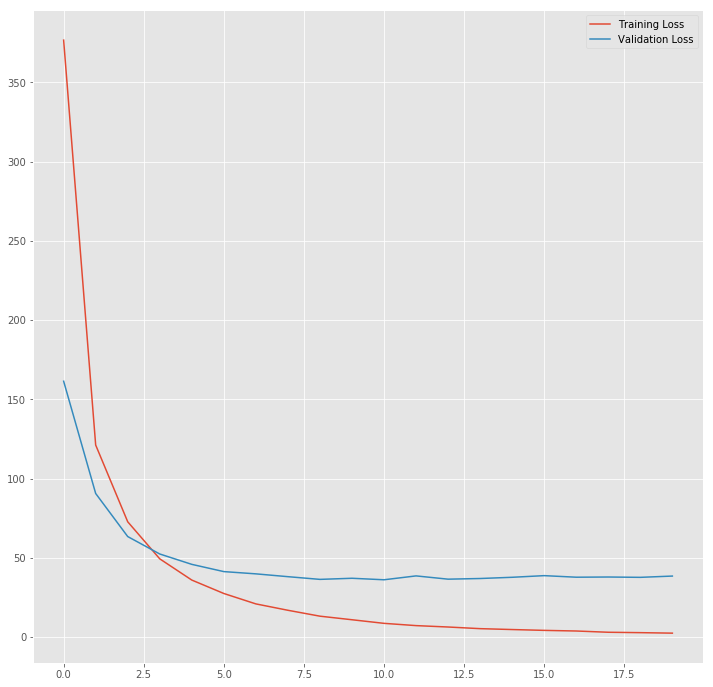

In [55]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

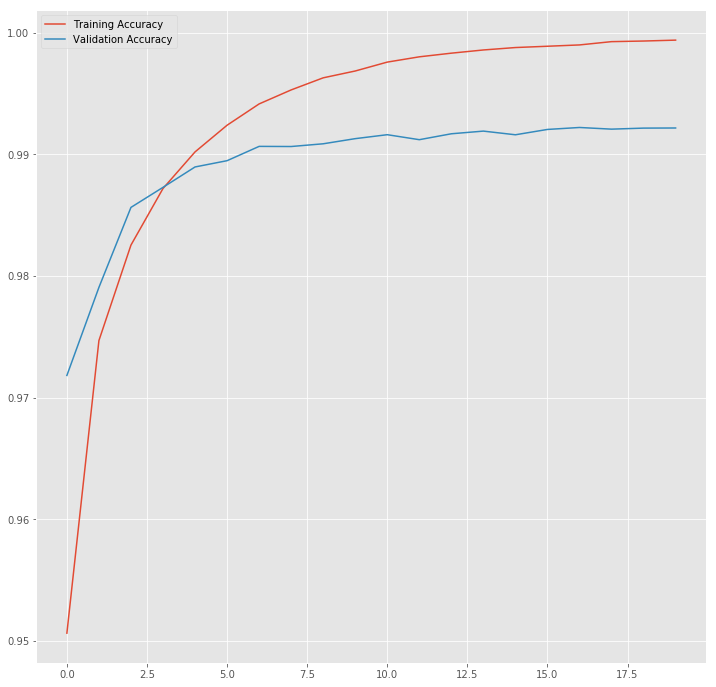

In [56]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"], label='Training Accuracy')
plt.plot(hist["val_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [113]:
from sklearn.metrics import classification_report

predicted = model.predict([X_word_te[:len(y_te)//32*32], X_pos_te[:len(y_te)//32*32],
                        np.array(X_char_te[:len(y_te)//32*32]).reshape((len(X_char_te[:len(y_te)//32*32]),
                                                     max_len, max_len_char))])
true = []
predicted_val = []
predicted_val2 = []
word = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    
    predicted_temp = predicted[i].copy()
    predicted_temp[:,0] = 0
    p2_tmp = np.argmax(predicted_temp, axis=-1)
    
    k = 0
    for p1,p2 in zip(p_tmp, p2_tmp):
        if p1 != p2:
            if predicted[i][k][p2] < 0.2:
                p2_tmp[k] = p1
        k+=1
    t_tmp = np.argmax(y_te[i], -1)
    word.append(X_word_te[i])
    predicted_val.append(p_tmp)
    predicted_val2.append(p2_tmp)
    true.append(t_tmp)

wd = [list(map(lambda x: y, y)) for y in word]    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
p2 = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val2]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
# print "\n"
print(report)

              precision    recall  f1-score   support

1_GO:0000380       1.00      1.00      1.00        13
1_GO:0000725       1.00      1.00      1.00         4
1_GO:0000803       1.00      1.00      1.00        10
1_GO:0000805       0.75      1.00      0.86         6
1_GO:0000806       0.89      1.00      0.94         8
1_GO:0001171       1.00      1.00      1.00         2
1_GO:0001654       1.00      1.00      1.00         1
1_GO:0001739       0.93      1.00      0.97        14
1_GO:0001741       0.97      0.97      0.97        31
1_GO:0001750       0.94      1.00      0.97        17
1_GO:0001822       0.75      1.00      0.86         3
1_GO:0001917       0.83      0.83      0.83         6
1_GO:0005634       1.00      0.67      0.80         6
1_GO:0005721       1.00      1.00      1.00         4
1_GO:0005886       0.94      0.89      0.91        18
1_GO:0006006       0.33      1.00      0.50         2
1_GO:0006260       0.38      1.00      0.55         3
1_GO:0006281       0.94    

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [114]:
i = 200
pred = np.argmax(predicted[i], axis=-1)
pred2 = np.argmax(predicted[i], axis=-1)
print(pred)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, tr, pred in zip(X_word_te[i], np.argmax(y_te[i], -1), pred):
    if w != 0:
        print("{:15}: {:5} {}".format(w, idx2tag[tr], idx2tag[pred]))
        
# pd = model.predict(np.array([X_te[i]]))
# pd = np.argmax(pd, axis=-1)
# true = np.argmax(y_te[i], -1)
# print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
# print(30 * "=")

# for w, t1, pred in zip(X_te[i], true, pd[0]):
#     if w != 0:
#         print("{:15}: {:5} {}".format(words[w-1], tags[t1], tags[pred]))

[ 0  0  0  0  0  0  0  0  0  0 59  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Word           ||True ||Pred
1999           : O     O
)              : O     O
,              : O     O
the            : O     O
predicted      : O     O
zebrafish      : O     O
tif1γ          : O     O
gene           : O     O
is             : O     O
broadly        : O     O
expressed      : GO:0010467 GO:0010467
(              : O     O
see            : O     O
Figure         : O     O
4A             : O     O
)              : O     O
.              : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
END

In [159]:
def print_report_with_unique_vals(report):
    reportlines = report.split('\n')
    print(reportlines[0]+ '\t  uniques\n')
    for i in reportlines[2:-4]:
        tag = i.split()[0]
        unique_vals = len(pd.Series([w[0] for s in data_list for w in s if w[1] == tag]).unique())
        print(i + '\t\t' + str(unique_vals))
    print('\n' + reportlines[-2] + '\n')

In [115]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Predicted2' : list(itertools.chain.from_iterable(p2)),
    'Ground Truth': list(itertools.chain.from_iterable(t)),
    'Word' : list(itertools.chain.from_iterable(wd)),
}
)


In [116]:
df = df[df['Word'] != 'O']

In [160]:
df1 = df[(df['Predicted'] != 'O') & (df['Ground Truth'] != 'O') | 
         (df['Predicted'] == 'O') & (df['Ground Truth'] != 'O') |
         (df['Predicted'] != 'O') & (df['Ground Truth'] == 'O')
        ]

report = classification_report(df1['Ground Truth'], 
                                    df1['Predicted'])
print("\n")
print_report_with_unique_vals(report)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)




              precision    recall  f1-score   support	  uniques

1_GO:0000380       1.00      1.00      1.00        13		4
1_GO:0000725       1.00      1.00      1.00         4		2
1_GO:0000803       1.00      1.00      1.00        10		1
1_GO:0000805       0.75      1.00      0.86         6		2
1_GO:0000806       0.89      1.00      0.94         8		1
1_GO:0001171       1.00      1.00      1.00         2		2
1_GO:0001654       1.00      1.00      1.00         1		2
1_GO:0001739       0.93      1.00      0.97        14		2
1_GO:0001741       0.97      0.97      0.97        31		3
1_GO:0001750       0.94      1.00      0.97        17		3
1_GO:0001822       0.75      1.00      0.86         3		2
1_GO:0001917       0.83      0.83      0.83         6		3
1_GO:0005634       1.00      0.67      0.80         6		4
1_GO:0005721       1.00      1.00      1.00         4		3
1_GO:0005886       0.94      0.89      0.91        18		4
1_GO:0006006       0.33      1.00      0.50         2		3
1_GO:0006260       0.

  GO:0005622       0.92      0.85      0.88        13		3
  GO:0005634       0.85      0.96      0.90       105		11
  GO:0005654       1.00      1.00      1.00         3		3
  GO:0005657       1.00      0.67      0.80         6		3
  GO:0005675       0.67      1.00      0.80         4		2
  GO:0005737       0.87      1.00      0.93        20		4
  GO:0005739       0.94      0.98      0.96        49		7
  GO:0005764       1.00      1.00      1.00        12		4
  GO:0005777       1.00      1.00      1.00         2		2
  GO:0005783       1.00      1.00      1.00         4		1
  GO:0005829       1.00      1.00      1.00         6		2
  GO:0005840       1.00      0.80      0.89         5		2
  GO:0005856       0.50      0.67      0.57         3		4
  GO:0005912       1.00      1.00      1.00         8		2
  GO:0006260       0.80      0.80      0.80         5		3
  GO:0006266       1.00      1.00      1.00         3		3
  GO:0006272       1.00      1.00      1.00         2		1
  GO:0006281       0.50      0

In [161]:
df2 = df[(df['Predicted2'] != 'O') & (df['Ground Truth'] != 'O') | 
         (df['Predicted2'] == 'O') & (df['Ground Truth'] != 'O') |
         (df['Predicted2'] != 'O') & (df['Ground Truth'] == 'O')
        ]

report = classification_report(df2['Ground Truth'], 
                                    df2['Predicted2'])
print("\n")
print_report_with_unique_vals(report)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)




              precision    recall  f1-score   support	  uniques

1_GO:0000380       0.87      1.00      0.93        13		4
1_GO:0000725       1.00      1.00      1.00         4		2
1_GO:0000803       1.00      1.00      1.00        10		1
1_GO:0000805       0.67      1.00      0.80         6		2
1_GO:0000806       0.89      1.00      0.94         8		1
1_GO:0001171       1.00      1.00      1.00         2		2
1_GO:0001654       1.00      1.00      1.00         1		2
1_GO:0001658       0.00      0.00      0.00         0		3
1_GO:0001739       0.93      1.00      0.97        14		2
1_GO:0001741       0.91      0.97      0.94        31		3
1_GO:0001750       0.89      1.00      0.94        17		3
1_GO:0001822       0.75      1.00      0.86         3		2
1_GO:0001917       0.83      0.83      0.83         6		3
1_GO:0005634       1.00      0.67      0.80         6		4
1_GO:0005721       1.00      1.00      1.00         4		3
1_GO:0005886       0.94      0.94      0.94        18		4
1_GO:0006006       0.

  GO:0000240       1.00      1.00      1.00        16		3
  GO:0000785       0.85      1.00      0.92        11		2
  GO:0000786       1.00      1.00      1.00         3		3
  GO:0000792       0.85      1.00      0.92        23		3
  GO:0001501       1.00      1.00      1.00         3		3
  GO:0001503       1.00      0.92      0.96        12		6
  GO:0001822       1.00      1.00      1.00         9		3
  GO:0005576       0.86      0.86      0.86         7		3
  GO:0005622       0.92      0.85      0.88        13		3
  GO:0005634       0.83      0.96      0.89       105		11
  GO:0005654       1.00      1.00      1.00         3		3
  GO:0005657       1.00      0.83      0.91         6		3
  GO:0005675       0.67      1.00      0.80         4		2
  GO:0005737       0.87      1.00      0.93        20		4
  GO:0005739       0.91      0.98      0.94        49		7
  GO:0005764       1.00      1.00      1.00        12		4
  GO:0005777       1.00      1.00      1.00         2		2
  GO:0005783       1.00      1

In [89]:
df.to_csv('../data/results/GO_merged_Elmo.tsv', sep='\t')

In [63]:
!python2.7 ComputeSim.py ../data/results/GO_merged_Elmo.tsv ../data/go/GO_AllSubsumers.tsv

('Mean semantic similarity: ', 0.884)
